# Data Cleaning and Exploratory Data Analysis

Our first goal is to explore the data obtained from IMDB and WIkipedia and see that they data is consistent and clean. We will then do some poreliminarfy analysis a out the various trends in predicting movie success b ased on revenues, IMDB votes and Academyy Award wins and nominations

In [49]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline

## Data Cleaning

THe acvquired data have been collected in the following data-structres and names: <br>
**Oscar categories and movie genres** THe hand-selected standard categories for the Acaemy Awards and the movie-genres are stored in the two followiong files. 
1. genre_dict = pickle.load(open("my_data_2/genre_dict","rb"))
2. main_categories_list = pickle.load(open("my_data_2/main_categories_list","rb")) 

The following dataframes have also been created:
1. df_oscars_films: DataFrame of films with wins('W'),nominations('N') or nothing('O') froim 1960 to 2019 oscars (films from 1959 to 2018)
2. df_oscars_individual: DataFRame of invidiaul categories (direcvtorsm, actors, supporting actrors, music, editing, etc)
3. df_imdb: Dataframe of movies scraped from IMDB.com (:pages1,2,3) and Wikpedia cointaining imdbID, votes, ratings, budget, box_office, running_time and cast_size
4. movie_info_dict: Dictionary of movie information for all the films in the above data frames combined

In [100]:
# Get preselected oscars info: Genres (genre_dict) and main oscar categories (main_categories)
genre_dict = pickle.load(open("my_data_3/genre_dict","rb"))
main_categories = pickle.load(open("my_data_3/main_categories","rb")) 
print(main_categories)

df_oscars = pd.read_csv('my_data_3/df_oscars_films.csv', index_col=[0])
df_oscars.reset_index(inplace=True)
df_oscars = df_oscars.rename(columns = {'index':'film'})
df_oscars.film = df_oscars.film.str.lower()

df_individual = pd.read_csv('my_data_3/df_oscars_individual.csv', index_col=[0])
df_movies = pd.read_csv('my_data_3/df_movies.csv', index_col=[0])


movie_dict = pickle.load(open("my_data_3/movie_info_dict","rb"))
# movie_info_2019 = pickle.load(open("my_data_3/movie_2019_dict","rb"))

['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay', 'music', 'cinematography', 'editing', 'effects', 'sound', 'costume', 'song', 'art_direction']


In [107]:
# print(df_oscars.head())
# print(df_individual.head())
print(df_oscars.head())



                      film actor actress art_direction cinematography costume  \
0       all the king's men     W       O             O              O       O   
1             battleground     O       O             O              W       O   
2              the heiress     O       W             W              N       W   
3  a letter to three wives     O       O             O              O       O   
4      twelve o'clock high     N       O             O              O       O   

  director editing effects music other picture s_actor s_actress screenplay  \
0        N       N       O     O     O       W       N         W          N   
1        N       N       O     O     W       N       N         O          O   
2        N       O       O     W     O       N       N         O          O   
3        W       O       O     O     O       N       O         O          W   
4        O       O       O     O     O       N       W         O          O   

  song sound  year  
0    O     O  194

In [102]:
len(movie_dict)
movie_dict['bombshell']
# movie_dict['a beautiful day in the neighborhood']

{'director': ['Jay Roach'],
 'genre': ['dra'],
 'producer': ['Aaron L. Glibert',
  'Jay Roach',
  'Robert Graf',
  'Michelle Graham',
  'Charles Randolph',
  'Margaret Riley',
  'Charlize Theron',
  'AJ Dix',
  'Beth Kono'],
 'screenplay': ['Charles Randolph'],
 'cast': ['Charlize Theron',
  'Nicole Kidman',
  'John Lithgow',
  'Kate McKinnon',
  'Connie Britton',
  'Malcolm McDowell',
  'Allison Janney',
  'Margot Robbie'],
 'music': ['Theodore Shapiro'],
 'cinematography': ['Barry Ackroyd'],
 'edit': ['Jon Poll'],
 'year': 2019,
 'running_time': 108,
 'language': ['English'],
 'budget': 32.0,
 'imdbID': 'tt0023825',
 'imdb_rating': 7.3,
 'n_votes': 2020,
 'title': 'bombshell'}

## Final Datastructures and functions

Ultimately, what do we want? We wants all oscar nominate movies from 1960 to 2018. We also want a list of the most popular/well-known and critically aclaimed movies from 1960 to 2018, which will ideally contain AL oscar nomiunatred movies aloing with the movie information (Wikipedia infobox). We want a data-frame of these movies with the proper information in the correct format (budget and box_office as floats, genre as a list etc.)

Scores:

We will also have a separate dataframe for thge 2019 movies which will be exactly as the other movies, except that they will have no post-oscar_score

In [96]:
# Manually fixing some outliers
# df_movies.loc[3807,'budget']=35.0
# df_movies.loc[4705,'budget']=11.0
# df_movies.loc[3807,'box_office']=13.75
# df_movies.loc[1,'box_office']=11.31

In [103]:
df_movies.sort_values(by='box_office',ascending=False).head(20)

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time
3807,tt1674784,trespass,1992,40016.0,5.3,14.0,1374713.87,4.0,101.0
1,tt0092997,extreme prejudice,1987,5649.0,6.7,22.0,1130784.49,3.0,104.0
7,tt1229238,mission: impossible,1996,435418.0,7.4,828.0,3570.00,1.0,769.0
9,tt1099212,twilight,2008,401686.0,5.2,385.0,3346.00,18.0,607.0
10,tt0077869,the lord of the rings,2001,28044.0,6.2,281.0,2919.00,15.0,558.0
5696,tt4154796,avengers: endgame,2019,613329.0,8.5,356.0,2798.00,16.0,181.0
109,tt0499549,avatar,2009,1069221.0,7.8,237.0,2790.00,5.0,161.0
11,tt0120338,titanic,1997,983627.0,7.8,200.0,2187.00,10.0,195.0
12,tt2488496,star wars: episode vii - the force awakens,2015,802470.0,7.9,306.0,2068.00,13.0,135.0
13,tt7768640,star wars: the force awakens,2015,8.0,6.0,306.0,2068.00,13.0,135.0


In [104]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4854 entries, 0 to 5879
Data columns (total 9 columns):
imdbID          4854 non-null object
title           4854 non-null object
year            4854 non-null int64
n_votes         4854 non-null float64
imdb_rating     4854 non-null float64
budget          4854 non-null float64
box_office      4854 non-null float64
cast            4854 non-null float64
running_time    4854 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 379.2+ KB


In [157]:
df_oscars.head()

,film,actor,actress,art_direction,cinematography,costume,director,editing,effects,music,other,picture,s_actor,s_actress,screenplay,song,sound,year
0,all the king's men,W,O,O,O,O,N,N,O,O,O,W,N,W,N,O,O,1949
1,battleground,O,O,O,W,O,N,N,O,O,W,N,N,O,O,O,O,1949
2,the heiress,O,W,W,N,W,N,O,O,W,O,N,N,O,O,O,O,1949
3,a letter to three wives,O,O,O,O,O,W,O,O,O,O,N,O,O,W,O,O,1949
4,twelve o'clock high,N,O,O,O,O,O,O,O,O,O,N,W,O,O,O,W,1949


# Exploratory Data Analysis

We will work with the following dataframes:
1. df_oscars_films
2. df_oscars_individuals
3. df_movies

From these, we will derive the following dataframes:
1. df_movies_wins_and_noms
2. df_ind_wins_and_noms

## Movies Wins and Nominations

First w enote that there are ~40 oscar nomiated movies that are not included in the movie dictionary (movie_dict)

In [116]:
oscars_set = set(df_oscars.query("year > 1960").film)
print(f'Total oscar nominated movie atre 1960: {len(oscars_set)}')
movies_set = set(df_movies.title)
print(f'Total movie in the list: {len(movies_set)}')
oscars_minus_imdb = list(oscars_set - movies_set)
print(f'Oscar nominated movies missing: {len(oscars_minus_imdb)}\n')

oscars_minus_imdb

Total oscar nominated movie atre 1960: 3044
Total movie in the list: 4854
Oscar nominated movies missing: 1740



['the painted door',
 'mephisto',
 'the little ark',
 'fighting for our lives',
 'the visit',
 'a woman under the influence',
 'curtain call',
 'american shoeshine',
 'from mao to mozart: isaac stern in china',
 'the last campaign of governor booth gardner',
 'the most dangerous man in america',
 'blake',
 'killing joe',
 'napoleon and samantha',
 'seven',
 'the violin',
 'la traviata',
 'tanna',
 'four days in september',
 'on body and soul',
 'i even met happy gypsies',
 'come blow your horn',
 'the crime of father amaro',
 'my country, my country',
 'sundays and cybele',
 'the organizer',
 'buster',
 'asad',
 'sweet and lowdown',
 'agueda martinez: our people, our country',
 "alice's restaurant",
 'claude lanzmann: spectres of the shoah',
 'nails',
 'little women',
 'the seven-per-cent solution',
 'grand canyon',
 'reuben, reuben',
 'universe',
 'when dinosaurs ruled the earth',
 "let's get lost",
 'scrooge',
 'badgered',
 'the tin drum',
 'double feature',
 'the battle over citizen

In [117]:
# df_oscars.set_index(range(len(df_oscars)))
df_oscars.head()
len(df_oscars.index.unique())

3745

In [131]:
## Number of wins and nomination for films
df_movies_wins_and_noms = pd.DataFrame()
cols = ['film','picture', 'director', 'actor', 'actress', 's_actor',
       's_actress', 'cinematography', 'screenplay', 'editing', 'costume',
       'effects', 'music', 'sound', 'art_direction', 'song']
# for row in df_oscars.iterrows():
#     df_movies_wins_and_noms = df_movies_wins_and_noms.append(row[1][cols].value_counts()).fillna(0)

df_oscars_long = pd.melt(df_oscars, id_vars = ['film', 'year'], var_name='category', value_name = 'result')
print(df_oscars_long.head())
df_oscars_long.query('year == 1981').query('result == "W"')



                      film  year category result
0       all the king's men  1949    actor      W
1             battleground  1949    actor      O
2              the heiress  1949    actor      O
3  a letter to three wives  1949    actor      O
4      twelve o'clock high  1949    actor      N


,film,year,category,result
1695,on golden pond,1981,actor,W
5440,on golden pond,1981,actress,W
9186,raiders of the lost ark,1981,art_direction,W
12932,reds,1981,cinematography,W
16673,chariots of fire,1981,costume,W
20422,reds,1981,director,W
24166,raiders of the lost ark,1981,editing,W
27911,raiders of the lost ark,1981,effects,W
31653,chariots of fire,1981,music,W
35410,mephisto,1981,other,W


## Most awarded genres

In [161]:
df_picture_wins = df_oscars[df_oscars.picture =='W']
df_picture_noms = df_oscars[df_oscars.picture !='O']
df_picture_wins.tail()

,film,actor,actress,art_direction,cinematography,costume,director,editing,effects,music,other,picture,s_actor,s_actress,screenplay,song,sound,year
3455,birdman or (the unexpected virtue of ignorance),N,O,O,W,O,W,N,O,O,O,W,N,N,W,O,N,2014
3515,spotlight,O,O,O,O,O,N,N,O,O,O,W,N,N,W,O,O,2015
3572,moonlight,O,O,O,N,O,N,N,O,N,O,W,W,N,W,O,O,2016
3634,the shape of water,O,N,O,N,N,W,N,O,W,W,W,N,N,N,O,N,2017
3693,green book,N,O,O,O,O,O,N,O,O,O,W,W,O,W,O,O,2018


Counter({'dra': 41, 'com': 14, 'epi': 13, 'his': 10, 'bio': 9, 'rom': 7, 'war': 6, 'mus': 5, 'thr': 5, 'cri': 5, 'adv': 3, 'psy': 3, 'act': 2, 'fan': 2, 'mys': 1, 'oth': 1, 'dis': 1})
Counter({'dra': 211, 'com': 73, 'bio': 49, 'rom': 43, 'epi': 35, 'his': 28, 'war': 24, 'cri': 23, 'thr': 23, 'mus': 19, 'oth': 14, 'fan': 11, 'adv': 10, 'psy': 10, 'act': 9, 'sci': 7, 'mys': 6, 'hor': 4, 'pol': 4, 'dis': 3, 'ani': 2, 'dys': 1, 'sup': 1})
winning genre
nominated genre


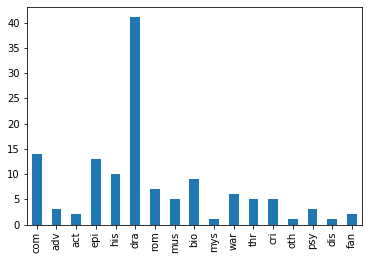

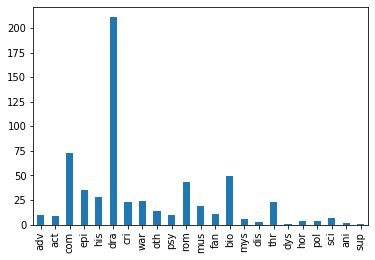

In [163]:
# The genres of winning movies
df_oscars.head()
df_picture_wins = df_oscars[df_oscars.picture =='W']
df_picture_noms = df_oscars[df_oscars.picture !='O']



win_genres = []
for title in df_picture_wins.film:
    if title in movie_dict:
        movie = movie_dict[title]
    else:
        continue
    if 'genre' in movie and movie['genre']!=None:
        win_genres = win_genres + movie['genre']

nom_genres = []
for title in df_picture_noms.film:
    if title in movie_dict:
        movie = movie_dict[title]
    else:
        continue
    if 'genre' in movie and movie['genre']!=None:
        nom_genres = nom_genres + movie['genre']

win_genre = collections.Counter(win_genres)  
nom_genre = collections.Counter(nom_genres)   

print(win_genre)
print(nom_genre)

print('winning genre')
pd.Series(dict(win_genre)).plot.bar()
plt.figure()
print('nominated genre')
pd.Series(dict(nom_genre)).plot.bar()



## Individual Wins and Nominations

In [165]:
print(f'Total number of individual winners in all categories combined: {len(set(df_individual.name))}')
most_noms = df_individual.name.value_counts()
most_wins = df_individual[df_individual.result=='N'].name.value_counts()
most_wins.head()

Total number of individual winners in all categories combined: 3181


John Williams      42
Edith Head         26
Hal Pereira        22
Alfred Newman      21
Lyle R. Wheeler    21
Name: name, dtype: int64

In [166]:
df_individual[df_individual.name == 'Maximilian Schell']

,year,name,category,result
10,1962,Maximilian Schell,actor,W
13,1976,Maximilian Schell,actor,N
24,1978,Maximilian Schell,s_actor,N


# Scoring films and individuals

In order to obtain a score for each film, we use the following function to give scores to winners and nominees based on the level of compeition foir each year and category. If a given year (1977) and category (Best Actor) has N nominees and 1 winner, then each winner gets 1 points and each nominee gets (1/N) points. This ensures that higher compeition yields higher points, but more nominations yield lower share. 

In [219]:
def oscar_score(df_long,categories,years):
    """
    This returns an oscar score for each year and fategory, 
    both for films and individuals, based competition.
    """
    
    # add the score column
    scores = []
    df = pd.DataFrame()

    
    if categories == 'all':
        categories = pickle.load(open("my_data_3/main_categories","rb"))
    for year in years:
        if year%10==0:
            print('In year:', year)
        for category in categories:
            # Only get winners and nominees for the year and category
            df_this = df_long[(df_long.year ==year) & (df_long.category==category)]
            if len(df_this)==0:
                print(f'Category {category} for {year} not avaialable')
                continue

            # Calculate score
            score = dict()
            n_wins = len(df_this[df_this.result=='W'])+len(df_this[df_this.result=='WN'])
            n_noms = len(df_this[df_this.result!='O'])
            
            if n_wins==0 or n_noms==0:
                print(f'No winner or nomination in {year} for category {category}')
                continue
            score['W']= min(6,n_noms/n_wins) # winner gets n points, more the competition, higher the point
            score['WN']= n_noms/n_wins
            score['N']= 1/n_noms # nominees share, more the nominees , less each one gets 
            score['O']= 0 # else zero points (not needed, shown for consistency)
            scores = [score[x] for x in df_this.result]
            df_this['score']=scores
            scores = []
            df = df.append(df_this)

            
    
    return df
    
  

In [220]:
df_oscars_long.head()

,film,year,category,result,score
0,all the king's men,1949,actor,W,0
1,battleground,1949,actor,O,0
2,the heiress,1949,actor,O,0
3,a letter to three wives,1949,actor,O,0
4,twelve o'clock high,1949,actor,N,0


In [221]:
categories = 'all'
df_oscar_score = oscar_score(df_oscars_long,categories,range(1955,2019))
df_oscar_score.head()


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In year: 1960
In year: 1970
No winner or nomination in 1972 for category effects
No winner or nomination in 1973 for category effects
No winner or nomination in 1974 for category effects
No winner or nomination in 1975 for category effects
No winner or nomination in 1976 for category effects
No winner or nomination in 1978 for category effects
In year: 1980
No winner or nomination in 1980 for category effects
No winner or nomination in 1983 for category effects
In year: 1990
No winner or nomination in 1990 for category effects
In year: 2000
In year: 2010
No winner or nomination in 2012 for category art_direction
No winner or nomination in 2013 for category art_direction
No winner or nomination in 2014 for category art_direction
No winner or nomination in 2015 for category art_direction
No winner or nomination in 2016 for category art_direction
No winner or nomination in 2017 for category art_direction
No winner or nomination in 2018 for category art_direction


,film,year,category,result,score
37801,marty,1955,picture,W,5.0
37802,love is a many-splendored thing,1955,picture,N,0.2
37803,mister roberts,1955,picture,N,0.2
37804,picnic,1955,picture,N,0.2
37805,the rose tattoo,1955,picture,N,0.2


In [35]:
print(df_individual.category.unique())
df_individual.head()

['picture' 'director' 'actor' 'actress' 's_actor' 's_actress' 'screenplay'
 'music' 'song' 'sound' 'art_direction' 'cinematography' 'costume'
 'editing' 'effects']


,year,name,category,result
0,1955.0,Sam Spiegel,picture,W
1,1955.0,Stanley Kramer,picture,N
2,1955.0,William Perlberg,picture,N
3,1955.0,Jack Cummings,picture,N
4,1955.0,Sol C. Siegel,picture,N


In [222]:
categories = pickle.load(open("my_data_3/main_categories","rb"))
# categories = ['director', 's_actress']
print(categories)

print(df_individual.category.unique())
df_indi_score = oscar_score(df_individual,categories,range(1940,2019))


['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay', 'music', 'cinematography', 'editing', 'effects', 'sound', 'costume', 'song', 'art_direction']
['picture' 'director' 'actor' 'actress' 's_actor' 's_actress' 'screenplay'
 'music' 'song' 'sound' 'art_direction' 'cinematography' 'editing'
 'effects' 'costume']
In year: 1940
Category picture for 1940 not avaialable
Category director for 1940 not avaialable
Category s_actor for 1940 not avaialable
Category s_actress for 1940 not avaialable
Category actor for 1940 not avaialable
Category actress for 1940 not avaialable
Category screenplay for 1940 not avaialable
Category music for 1940 not avaialable
Category cinematography for 1940 not avaialable
Category editing for 1940 not avaialable
Category effects for 1940 not avaialable
Category sound for 1940 not avaialable
Category costume for 1940 not avaialable
Category song for 1940 not avaialable
Category art_direction for 1940 not avaialable
Category picture for 

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Category costume for 1945 not avaialable
Category costume for 1946 not avaialable
Category costume for 1947 not avaialable
Category costume for 1948 not avaialable
In year: 1950
Category effects for 1952 not avaialable
Category effects for 1953 not avaialable
Category effects for 1954 not avaialable
No winner or nomination in 1955 for category effects
No winner or nomination in 1956 for category effects
In year: 1960
In year: 1970
Category effects for 1973 not avaialable
Category effects for 1974 not avaialable
Category effects for 1975 not avaialable
Category effects for 1976 not avaialable
Category effects for 1977 not avaialable
Category effects for 1979 not avaialable
In year: 1980
Category effects for 1981 not avaialable
Category effects for 1984 not avaialable
In year: 1990
Category effects for 1991 not avaialable
In year: 2000
In year: 2010
Category art_direction for 2013 not avaialable
Category art_direction for 2014 not avaialable
Category art_direction for 2015 not avaialable

,year,name,category,result,score
48,1945,Michel Michelet,music,N,0.029412
49,1945,Robert Stolz,music,N,0.029412
50,1945,Frederic Efrem Rich,music,N,0.029412
51,1945,Herbert Stothart,music,N,0.029412
52,1945,Hanns Eisler,music,N,0.029412
53,1945,David Rose,music,N,0.029412
54,1945,Karl Hajos,music,N,0.029412
55,1945,W. Franke Harling,music,N,0.029412
56,1945,Edward Paul,music,N,0.029412
57,1945,Michel Michelet,music,N,0.029412


In [228]:
df_indi_score.query("year == 1998").query("category == 'screenplay'")

,year,name,category,result,score
30,1998,Matt Damon,screenplay,W,5.0
31,1998,Mark Andrus,screenplay,N,0.1
32,1998,Paul Thomas Anderson,screenplay,N,0.1
33,1998,Woody Allen,screenplay,N,0.1
34,1998,Simon Beaufoy,screenplay,N,0.1
35,1998,Brian Helgeland,screenplay,W,5.0
36,1998,Paul Attanasio,screenplay,N,0.1
37,1998,Atom Egoyan,screenplay,N,0.1
38,1998,David Mamet,screenplay,N,0.1
39,1998,Hossein Amini,screenplay,N,0.1


# The Pre-Oscar Score

Each movie, based on its cast, director, writer, editor etc., will be scored based on what awards and nominations. This scoring will include the 2019 movies. 

In [319]:
def pre_oscar_score(df_movies, categories, movie_dict, df_score):
    
    """
    takes a year and title of a film and gives it a totla score based on Oscar records of actors, 
    directors and editorial crew
    """
    if categories == 'all':
                categories = pickle.load(open("my_data_3/main_categories","rb"))
    
    df_movies['prescore'] = 0 # initialize all socre to zero
            
    for row in df_movies.iterrows(): # go through each movie
        idx = row[0]
        if idx%50==0:
            print(f'{idx}of {len(df_movies)}')
        title = row[1].title
        year = row[1].year
        movie = movie_dict[title]
        
        # get all_members from the infobox information in movie_dict
        score = 0
        checked_members = [] # to prevent double counting if any personnel is repeated (example: director and writer)
        
        # aggregate accross categories and members
        for field in movie:
            if type(movie[field])==list:
                for member in movie[field]:
                    if member in checked_members:
                        continue
                    checked_members.append(member)
                    for category in categories:
                        score = score + df_score[(df_score.year <year) & (df_score.name == member)& (df_score.category == category)].score.sum()
        df_movies.loc[idx,'prescore'] = score    
    
    return df_movies
          
#                 all_members = all_members + movie[field]
#         all_members = list(set(all_members))

#         # for each member in all_members, obtain total score from past years
#         for member in all_members:
#             for category in categories:
#                 score = score + df_score[(df_score.year <year) & (df_score.name == member)& (df_score.category == category)].score.sum()
#                 # print(member, category, score)
        
        
        
    
    
    

In [ ]:
df_with_prescore = pre_oscar_score(df_movies, 'all', movie_dict, df_indi_score)

0of 4854
50of 4854
100of 4854
150of 4854
300of 4854
350of 4854
400of 4854
450of 4854
500of 4854
550of 4854
600of 4854
650of 4854
700of 4854
750of 4854
800of 4854
850of 4854
900of 4854
950of 4854
1000of 4854
1050of 4854
1100of 4854
1150of 4854
1200of 4854
1250of 4854
1300of 4854
1350of 4854
1400of 4854
1450of 4854
1500of 4854
1550of 4854
1600of 4854
1650of 4854
1700of 4854
1750of 4854
1800of 4854
1850of 4854
1900of 4854
1950of 4854
2000of 4854
2050of 4854
2100of 4854
2150of 4854
2200of 4854
2250of 4854
2300of 4854
2350of 4854
2400of 4854
2450of 4854
2500of 4854
2550of 4854
2600of 4854
2650of 4854
2700of 4854
2750of 4854
2800of 4854
2850of 4854
2900of 4854
2950of 4854
3000of 4854
3050of 4854
3100of 4854
3150of 4854
3200of 4854
3250of 4854
3300of 4854
3350of 4854
3400of 4854
3500of 4854


In [315]:
# title = "ben-hur"
# year = 1959
# categories = 'all'
# print(movie_dict[title])
# pre_oscar_score(title,year,categories,movie_dict[title], df_indi_score)

print(df_movies.shape)
df_movies.head()
print(main_categories)


(4854, 9)
['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay', 'music', 'cinematography', 'editing', 'effects', 'sound', 'costume', 'song', 'art_direction']
